### Object vs. scene categorization

In this notebook, we investigate the ability of a brain-injured patient with a category-specific impairment of semantic memory to perform scene- and object-categorization tasks. 

We compare performance to performance of different DCNN architectures 




In [1]:
import pickle
import mne
import numpy as np
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import csv
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from scipy.stats import pearsonr, spearmanr, kendalltau, norm, ttest_1samp
from scipy.stats import t as t_dist
from scipy.spatial.distance import squareform, pdist
from copy import deepcopy
import nibabel as nib
from scipy.interpolate import interp1d
import warnings
import itertools
from joblib import Parallel, delayed
import six
from scipy.linalg import orthogonal_procrustes
from scipy.spatial import procrustes as procrust
from scipy.ndimage import label, generate_binary_structure
from sklearn.utils import check_random_state
from sklearn.metrics import pairwise_distances
MAX_INT = np.iinfo(np.int32).max

### Experiment 1: manmade vs. natural scenes

In [53]:
data=pd.read_csv('E:/Projects/2020_lesion/EEG/MSmanmade_natural1.txt',  quoting=csv.QUOTE_NONE, error_bad_lines=False, sep='\t', index_col=False, header=0)
data.head(5)

,trial_index,img,CE,SC,rating,condition,complexity,rating_recoded,Resp2,RT2,Target2,Correct2,Natural2,Time,Resp,RT,Target
0,55,1,0.289840,0.583087,0.035714,manmade,low,0,2,2910,1,0,1,356116,2,2910,1
1,224,2,0.569761,0.396073,0.000000,manmade,low,0,2,3311,1,0,1,1547388,2,3311,1
2,91,3,0.269085,1.092327,0.035714,manmade,high,0,2,3156,1,0,1,629594,2,3156,1
3,46,4,1.209567,0.682170,0.035714,manmade,low,0,1,3230,1,1,0,310482,1,3230,1
4,240,5,0.372978,0.971881,0.000000,manmade,med,0,1,2676,1,1,0,1629455,1,2676,1


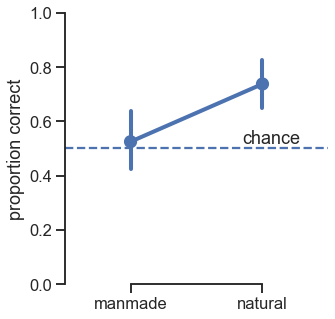

In [3]:
sns.set(style="ticks")
sns.set_context('talk')
g = sns.catplot(x="condition", y="Correct2", kind="point", data=data[data['condition']!="ambiguous"],ci=95, order=['manmade', 'natural'])
(g.set(ylim=(0, 1)))
g.axes[0][0].axhline(0.5, ls='--')
g.axes[0][0].text(0.85,0.52, "chance")
g.set_axis_labels("", "proportion correct")
g.despine(trim=True)

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
          yticks=np.arange(cm.shape[0]),
          xticklabels=classes, yticklabels=classes,
          title=title,
          ylabel='Category',
          xlabel='Response')
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i,j], fmt),
                   ha='center', va='center',
                   color='white' if cm[i,j] > thresh else 'black')
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[42 38]
 [21 59]]


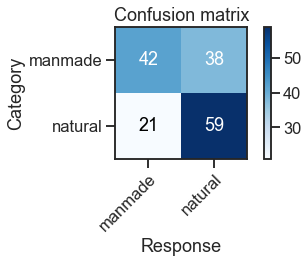

In [5]:
classes = ['manmade', 'natural']
data=data[data['condition']!="ambiguous"]
plot_confusion_matrix(data['Target2'], data['Resp2'], classes, normalize=False, title='Confusion matrix')

In [6]:
def _permute_sign(data, random_state=None):
    random_state = check_random_state(random_state)
    return np.mean(data*random_state.choice([1, -1], len(data)))


def _permute_group(data, random_state=None):
    random_state = check_random_state(random_state)
    perm_label = random_state.permutation(data['Group'])
    return (np.mean(data.loc[perm_label == 1, 'Values']) - np.mean(data.loc[perm_label == 0, 'Values']))


def _calc_pvalue(all_p, stat, tail):
    denom = float(len(all_p)) + 1
    if tail == 2:
        numer = np.sum(np.abs(all_p) >= np.abs(stat)) + 1
    elif tail == 1:
        if stat >= 0:
            numer = np.sum(all_p >= stat) + 1
        else:
            numer = np.sum(all_p <= stat) + 1
    else:
        raise ValueError('tail must be either 1 or 2')
    p = numer / denom
    return p


def two_sample_permutation(data1, data2, n_permute=5000,
                           tail=2, n_jobs=-1, return_perms=False, random_state=None):

    random_state = check_random_state(random_state)
    seeds = random_state.randint(MAX_INT, size=n_permute)

    stats = dict()
    stats['mean'] = np.nanmean(data1)-np.nanmean(data2)
    data = pd.DataFrame(data={'Values': data1, 'Group': np.ones(len(data1))})
    data = data.append(pd.DataFrame(data={'Values': data2,'Group': np.zeros(len(data2))}))
    all_p = Parallel(n_jobs=n_jobs)(delayed(_permute_group)(data,random_state=seeds[i]) for i in range(n_permute))

    stats['p'] = _calc_pvalue(all_p, stats['mean'], tail)
    if return_perms:
        stats['perm_dist'] = all_p
    return stats


In [7]:
c1 = data[data['condition']=="manmade"]["Correct2"]
c2 = data[data['condition']=="natural"]["Correct2"]
stats = two_sample_permutation(c1, c2, n_permute=5000, return_perms=True)
print(stats['p'])

0.006798640271945611


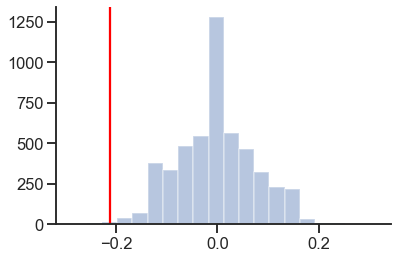

In [8]:
ax = sns.distplot(stats['perm_dist'], kde=False, bins=20)
sns.despine(right=True)
plt.axvline(stats['mean'], color='red')

In [9]:
### Find incorrect / correct images to index DCNN performance 
correct_imgs_exp1 = data[data['Correct2']==1]['img'] 

### Experiment 2: manmade vs. natural objects 

In [11]:
data=pd.read_csv('E:/Projects/2020_lesion/EEG/MSanimate_inanimate1.txt',  quoting=csv.QUOTE_NONE, error_bad_lines=False, sep='\t', index_col=False, header=0)
unsegmented = np.arange(1,321,4)
segmented=unsegmented+1
stripes=unsegmented+2
wallpaper=unsegmented+3

data.head(5)

mammal_list = np.arange(1,81)
insect_list = np.arange(81,161)
vehicle_list = np.arange(161,241)
furniture_list = np.arange(241,321)

data.loc[data["Pic"] <81, "ordinate"] = "mammal"
data.loc[(data["Pic"] > 80) & (data["Pic"] < 161), "ordinate"] = "insect"
data.loc[(data["Pic"] > 160) & (data["Pic"] < 241), "ordinate"] = "vehicle"
data.loc[(data["Pic"] > 240), "ordinate"] = "furniture"

data.loc[data["Pic"] <41, "subordinate"] = "dog"
data.loc[(data["Pic"] > 40) & (data["Pic"] < 81), "subordinate"] = "cat"
data.loc[(data["Pic"] > 80) & (data["Pic"] < 121), "subordinate"] = "butterfly"
data.loc[(data["Pic"] > 120) & (data["Pic"] < 161), "subordinate"] = "fly"
data.loc[(data["Pic"] > 160) & (data["Pic"] < 201), "subordinate"] = "car"
data.loc[(data["Pic"] > 200) & (data["Pic"] < 241), "subordinate"] = "bus"
data.loc[(data["Pic"] > 240) & (data["Pic"] < 281), "subordinate"] = "cabinet"
data.loc[(data["Pic"] > 280), "subordinate"] = "chair"

data.dropna()
data['Pic'] = data['Pic'].apply(lambda x: '{0:0>3}'.format(x))



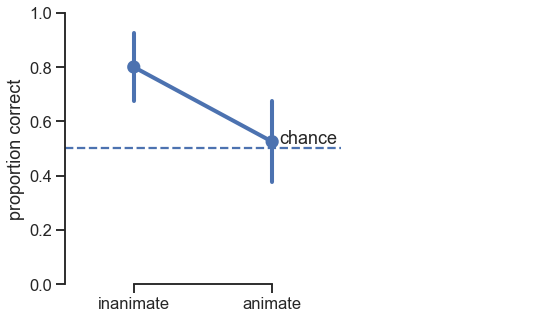

In [12]:
sns.set(style="ticks")
sns.set_context('talk')

g = sns.catplot(x="Condition", y="Correct", kind="point",ci=95,data=data, order=["inanimate", "animate"])
(g.set(ylim=(0, 1)))

g.axes[0][0].axhline(0.5, ls='--')
g.axes[0][0].text(1.05,0.52, "chance")
g.set_axis_labels("", "proportion correct")

g.add_legend(bbox_to_anchor=(1.5, 0.325))
# replace labels
new_labels = ['MS']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

g.despine(trim=True)



In [13]:
classes =['inanimate', 'animate']

Confusion matrix, without normalization
[[21 19]
 [ 8 32]]


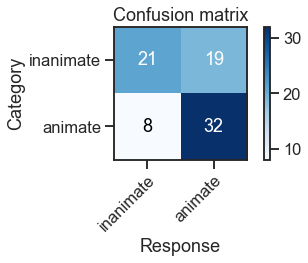

In [14]:
sns.set(style="ticks")
sns.set_context('talk')
plot_confusion_matrix(data['Target'], data['Resp'], classes, normalize=False, title='Confusion matrix')

In [15]:
c1 = data[data['Condition']=="animate"]["Correct"]
c2 = data[data['Condition']=="inanimate"]["Correct"]

stats = two_sample_permutation(c1, c2, n_permute=5000, return_perms=True)
print(stats['p'])

0.019596080783843232


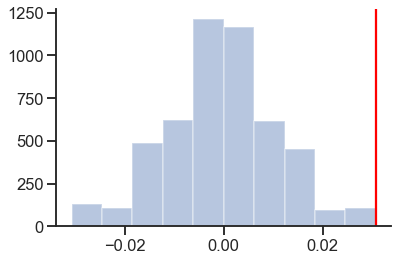

In [55]:
ax = sns.distplot(stats['perm_dist'], kde=False, bins=10)
sns.despine(right=True)
plt.axvline(stats['mean'], color='red')


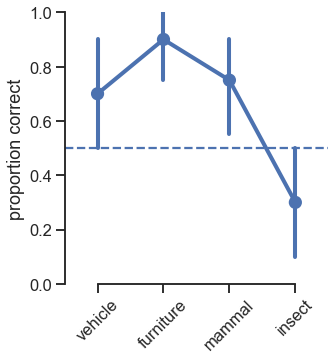

In [17]:
sns.set(style="ticks")
sns.set_context('talk')

g = sns.catplot(x="ordinate", y="Correct", kind="point",ci=95,data=data, order=['vehicle', 'furniture','mammal','insect'])

(g.set(ylim=(0, 1)))

g.axes[0][0].axhline(0.5, ls='--')


g.set_axis_labels("", "proportion correct")
g.set_xticklabels(rotation=45)
g.despine(trim=True)



In [18]:
c1 = data[data['ordinate']=="vehicle"]["Correct"]
c2 = data[data['ordinate']=="furniture"]["Correct"]

stats = two_sample_permutation(c1, c2, n_permute=5000, return_perms=True)
print(stats['p'])


0.23215356928614278


In [19]:
c1 = data[data['ordinate']=="vehicle"]["Correct"]
c2 = data[data['ordinate']=="mammal"]["Correct"]

stats = two_sample_permutation(c1, c2, n_permute=5000, return_perms=True)
print(stats['p'])

1.0


In [20]:
c1 = data[data['ordinate']=="vehicle"]["Correct"]
c2 = data[data['ordinate']=="insect"]["Correct"]

stats = two_sample_permutation(c1, c2, n_permute=5000, return_perms=True)
print(stats['p'])

0.028594281143771244


In [21]:
c1 = data[data['ordinate']=="furniture"]["Correct"]
c2 = data[data['ordinate']=="insect"]["Correct"]

stats = two_sample_permutation(c1, c2, n_permute=5000, return_perms=True)
print(stats['p'])

0.0003999200159968006


In [22]:
c1 = data[data['ordinate']=="furniture"]["Correct"]
c2 = data[data['ordinate']=="mammal"]["Correct"]

stats = two_sample_permutation(c1, c2, n_permute=5000, return_perms=True)
print(stats['p'])

0.39992001599680066


In [23]:
c1 = data[data['ordinate']=="mammal"]["Correct"]
c2 = data[data['ordinate']=="insect"]["Correct"]

stats = two_sample_permutation(c1, c2, n_permute=5000, return_perms=True)
print(stats['p'])

0.010597880423915218


In [24]:
### Find incorrect / correct images to index DCNN performance 
correct_imgs_exp2 = data[data['Correct']==1]['Pic'] 

### ResNet behavior

#### manmade vs. natural

In [56]:
models = ['resnet6', 'resnet10', 'resnet18', 'resnet34']
data= pd.DataFrame()
for model in models:    
    for ii in range(5):
        data2append = pd.read_csv('E:/Projects/2020_lesion/DCNN/Results/'+model+'_' +str(ii)+'_manmade_natural_all.tsv',  quoting=csv.QUOTE_NONE, error_bad_lines=False, sep='\t', index_col=False, header=0) 
        data2append['initialization']=ii
        data2append['model']=model
        data=data.append(data2append)

In [57]:
data['image'] = data['imageID'].str.strip().str[-7:-4].astype(int)
data['correct'] = np.where(data["pred"]==data["ground"],1,0)
data['condition'] = np.where(data['image']<81,"manmade","natural")

In [58]:
data['MScorrect']= np.where(data['image'].isin(correct_imgs_exp1), 1,0)
correctT = data.groupby(['model', 'initialization', 'condition'], as_index=False)['correct'].mean()
data.to_csv("check_errors_ResNets.csv")
data.head(3)

,Unnamed: 0,imageID,pred,ground,initialization,model,image,correct,condition,MScorrect
0,0,E:/Projects/2020_lesion/stim/manmade_natural\m...,[0],[0],0,resnet6,1,1,manmade,0
1,1,E:/Projects/2020_lesion/stim/manmade_natural\m...,[0],[0],0,resnet6,2,1,manmade,0
2,2,E:/Projects/2020_lesion/stim/manmade_natural\m...,[0],[0],0,resnet6,3,1,manmade,0


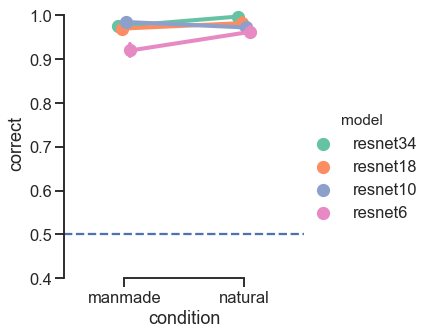

In [29]:
sns.set(style="ticks")
sns.set_context('talk')
ax = sns.catplot(x="condition", y="correct", hue="model", hue_order=['resnet34','resnet18','resnet10','resnet6'],
                   data=correctT, palette="Set2",kind="point",dodge=True )
ax.axes[0][0].axhline(0.5, ls='--')
(ax.set(ylim=(0.4, 1.02)))
ax.despine(trim=True)


In [30]:
dataa= data[data['model']=='resnet6']
c1 = dataa[dataa['condition']=="manmade"]["correct"]
c2 = dataa[dataa['condition']=="natural"]["correct"]

stats = two_sample_permutation(c1, c2, n_permute=5000, return_perms=True)
print(stats['p'])


0.016996600679864027


### ResNet performance experiment 2

#### inanimate vs. animate

In [31]:
models = ['resnet6', 'resnet10', 'resnet18', 'resnet34']
data= pd.DataFrame()
for model in models:    
    for ii in range(5):
        data2append = pd.read_csv('E:/Projects/2020_lesion/DCNN/Results/'+model+'_' +str(ii)+'_animate_inanimate_all.tsv',  quoting=csv.QUOTE_NONE, error_bad_lines=False, sep='\t', index_col=False, header=0) 
        data2append['initialization']=ii
        data2append['model']=model
        data=data.append(data2append)

data['correct'] = np.where(data["pred"]==data["ground"],1,0)
data['condition']=data['imageID'].str.split(r'\\').str[-2] 
data['img']=data['imageID'].str[-7:-4].astype(int)

data.loc[data["img"] <81, "ordinate"] = "mammal"
data.loc[(data["img"] > 80) & (data["img"] < 161), "ordinate"] = "insect"
data.loc[(data["img"] > 160) & (data["img"] < 241), "ordinate"] = "vehicle"
data.loc[(data["img"] > 240), "ordinate"] = "furniture"

data.loc[data["img"] <41, "subordinate"] = "dog"
data.loc[(data["img"] > 40) & (data["img"] < 81), "subordinate"] = "cat"
data.loc[(data["img"] > 80) & (data["img"] < 121), "subordinate"] = "butterfly"
data.loc[(data["img"] > 120) & (data["img"] < 161), "subordinate"] = "fly"
data.loc[(data["img"] > 160) & (data["img"] < 201), "subordinate"] = "car"
data.loc[(data["img"] > 200) & (data["img"] < 241), "subordinate"] = "bus"
data.loc[(data["img"] > 240) & (data["img"] < 281), "subordinate"] = "cabinet"
data.loc[(data["img"] > 280), "subordinate"] = "chair"

data.head(3)

,Unnamed: 0,imageID,pred,ground,initialization,model,correct,condition,img,ordinate,subordinate
0,0,E:/Projects/2020_lesion/stim/animate_inanimate...,[0],[0],0,resnet6,1,animate,1,mammal,dog
1,1,E:/Projects/2020_lesion/stim/animate_inanimate...,[0],[0],0,resnet6,1,animate,5,mammal,dog
2,2,E:/Projects/2020_lesion/stim/animate_inanimate...,[0],[0],0,resnet6,1,animate,9,mammal,dog
3,3,E:/Projects/2020_lesion/stim/animate_inanimate...,[0],[0],0,resnet6,1,animate,13,mammal,dog
4,4,E:/Projects/2020_lesion/stim/animate_inanimate...,[0],[0],0,resnet6,1,animate,17,mammal,dog


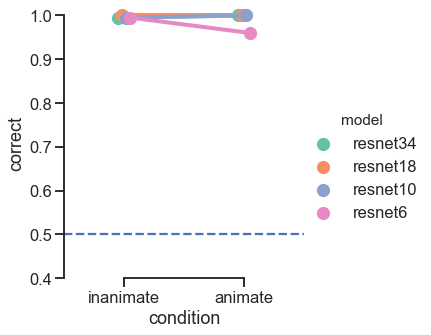

In [32]:
correctT = data.groupby(['model', 'initialization', 'condition'], as_index=False)['correct'].mean()
sns.set(style="ticks")
sns.set_context('talk')
ax = sns.catplot(x="condition", y="correct", hue="model", hue_order=['resnet34','resnet18','resnet10','resnet6'],
                   data=correctT, palette="Set2",kind="point", dodge=True, ci=95, order=['inanimate', 'animate'])
ax.axes[0][0].axhline(0.5, ls='--')
(ax.set(ylim=(0.4, 1.02)))
ax.despine(trim=True)


In [33]:
dataa= data[data['model']=='resnet6']
c1 = dataa[dataa['condition']=="inanimate"]["correct"]
c2 = dataa[dataa['condition']=="animate"]["correct"]
stats = two_sample_permutation(c1, c2, n_permute=5000, return_perms=True)
print(stats['p'])

0.03519296140771846


#### LESIONED RESNET10

In [64]:
models = ["resnet10",'r10L1','r10L2','r10L3', 'r10L4']
data= pd.DataFrame()
for model in models:    
    for ii in range(5):
        if model == 'resnet10':
            data2append = pd.read_csv('E:/Projects/2020_lesion/DCNN/Results/'+model+'_' +str(ii)+'_animate_inanimate_all.tsv',  quoting=csv.QUOTE_NONE, error_bad_lines=False, sep='\t', index_col=False, header=0) 
            data2append['condition']=data2append['imageID'].str.split(r'\\').str[-2] 
            data2append['img'] = data2append['imageID'].str.split("\\").str[-1]

        else:
            data2append = pd.read_csv('E:/Projects/2020_lesion/DCNN/Results/'+model+'_' +str(ii)+'_animate_inanimate_all.tsv',  quoting=csv.QUOTE_NONE, error_bad_lines=False, sep='\t', index_col=False, header=0)
            data2append['condition']=data2append['imageID'].str.split('\\').str[-2] 
            data2append['img'] = data2append['imageID'].str.split("\\").str[-1]

        data2append['initialization']=ii
        data2append['model']=model
        data=data.append(data2append)
data.head(3)

,Unnamed: 0,imageID,pred,ground,condition,img,initialization,model
0,0,E:/Projects/2020_lesion/stim/animate_inanimate...,[0],[0],animate,im_001.jpg,0,resnet10
1,1,E:/Projects/2020_lesion/stim/animate_inanimate...,[0],[0],animate,im_005.jpg,0,resnet10
2,2,E:/Projects/2020_lesion/stim/animate_inanimate...,[0],[0],animate,im_009.jpg,0,resnet10


In [65]:
data['Pic']=data['img'].str[-7:-4].astype(int)

data.loc[data["Pic"] <81, "ordinate"] = "mammal"
data.loc[(data["Pic"] > 80) & (data["Pic"] < 161), "ordinate"] = "insect"
data.loc[(data["Pic"] > 160) & (data["Pic"] < 241), "ordinate"] = "vehicle"
data.loc[(data["Pic"] > 240), "ordinate"] = "furniture"

data.loc[data["Pic"] <41, "subordinate"] = "dog"
data.loc[(data["Pic"] > 40) & (data["Pic"] < 81), "subordinate"] = "cat"
data.loc[(data["Pic"] > 80) & (data["Pic"] < 121), "subordinate"] = "butterfly"
data.loc[(data["Pic"] > 120) & (data["Pic"] < 161), "subordinate"] = "fly"
data.loc[(data["Pic"] > 160) & (data["Pic"] < 201), "subordinate"] = "car"
data.loc[(data["Pic"] > 200) & (data["Pic"] < 241), "subordinate"] = "bus"
data.loc[(data["Pic"] > 240) & (data["Pic"] < 281), "subordinate"] = "cabinet"
data.loc[(data["Pic"] > 280), "subordinate"] = "chair"

In [66]:
data['correct'] = np.where(data["pred"]==data["ground"],1,0)
data['MScorrect']= np.where(data['Pic'].isin(correct_imgs_exp2), 1,0)

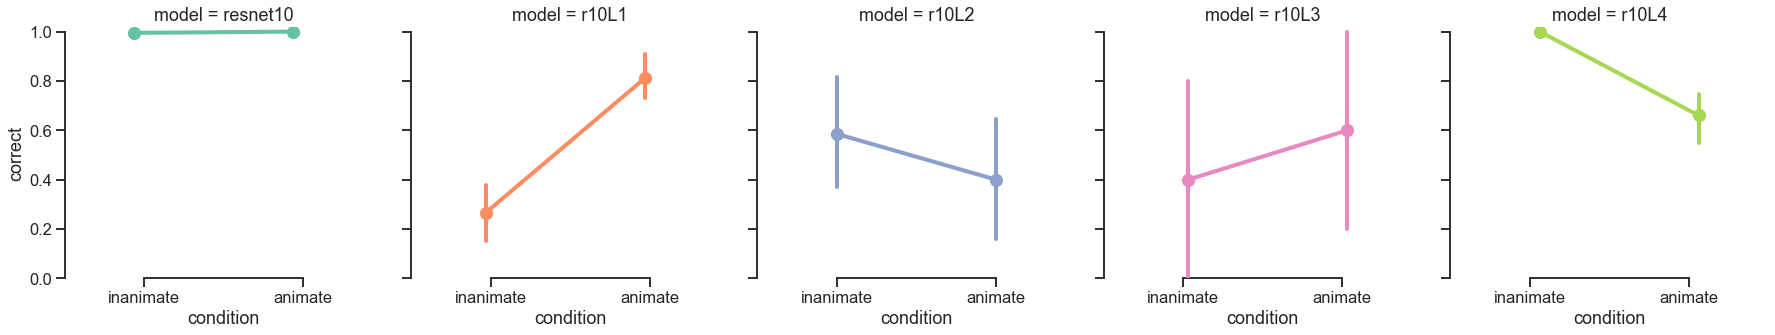

In [67]:
correctT = data.groupby(['model', 'initialization', 'condition'], as_index=False)['correct'].mean()
sns.set(style="ticks")
sns.set_context('talk')

ax = sns.catplot(x="condition", order=["inanimate","animate"], y="correct",hue='model', hue_order=['resnet10', 'r10L1', 'r10L2', 'r10L3', 'r10L4'],col="model", col_order=["resnet10", "r10L1", "r10L2","r10L3","r10L4"],
                   data=correctT, palette="Set2",kind="point", dodge=True, ci=95, join=True, legend=False)
(ax.set(ylim=(0, 1.02)))
ax.despine(trim=True)

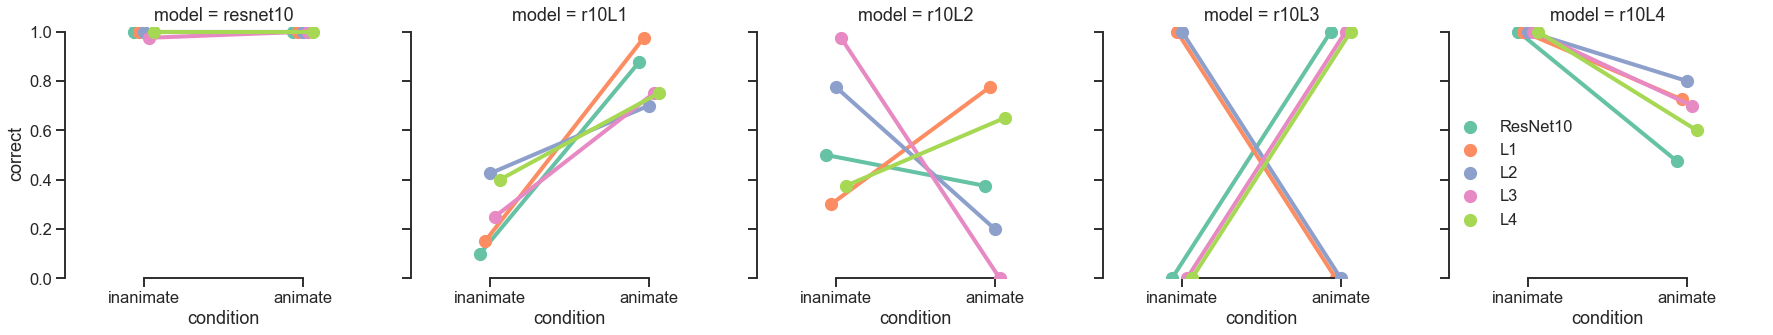

In [68]:
correctT = data.groupby(['model', 'initialization', 'condition'], as_index=False)['correct'].mean()
sns.set(style="ticks")
sns.set_context('talk')

ax = sns.catplot(x="condition", order=["inanimate","animate"], y="correct",hue='initialization',style='initialization', col="model", col_order=["resnet10", "r10L1", "r10L2","r10L3","r10L4"],
                   data=correctT, palette="Set2",kind="point", dodge=True, ci=95, join=True, legend=False)
(ax.set(ylim=(0, 1.02)))
ax.add_legend(bbox_to_anchor=(0.85, 0.45))
# replace labels
new_labels = ['ResNet10','L1','L2','L3','L4']
for t, l in zip(ax._legend.texts, new_labels): t.set_text(l)
ax.despine(trim=True)

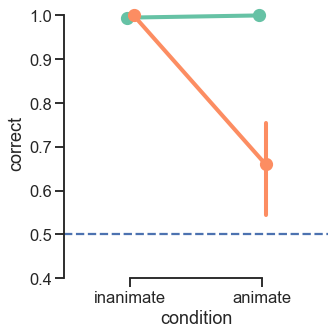

In [69]:
sns.set(style="ticks")
sns.set_context('talk')

ax = sns.catplot(x="condition", order = ['inanimate', 'animate'], y="correct", hue="model", hue_order=['resnet10', 'r10L4'],
                   data=correctT, palette="Set2",kind="point",dodge=True, legend=False)
(ax.set(ylim=(0, 1.02)))
ax.axes[0][0].axhline(0.5, ls='--')
(ax.set(ylim=(0.4, 1.02)))
ax.despine(trim=True)

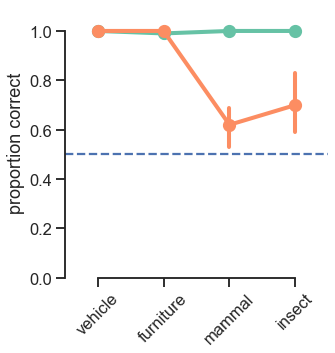

In [70]:
sns.set(style="ticks")
sns.set_context('talk')
g = sns.catplot(x="ordinate", y="correct", kind="point",ci=95,data=data.groupby(['model', 'initialization', 'ordinate'], as_index=False)['correct'].mean(),hue="model", hue_order=['resnet10', 'r10L4'],
                order=['vehicle', 'furniture','mammal','insect'],palette="Set2", legend=False)
(g.set(ylim=(0, 1.1)))
g.axes[0][0].axhline(0.5, ls='--')
g.set_axis_labels("", "proportion correct")
g.set_xticklabels(rotation=45)
g.despine(trim=True)

### Test whether ResNet10-Lesion makes same mistakes as MS

In [71]:
correctMS = data.groupby(['model', 'initialization', 'MScorrect'], as_index=False)['correct'].mean()
correctMS.head(3)

,model,initialization,MScorrect,correct
0,r10L1,0,0,0.629630
1,r10L1,0,1,0.415094
2,r10L1,1,0,0.703704


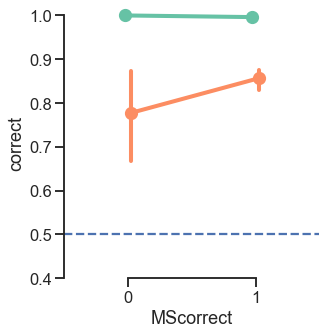

In [72]:
sns.set(style="ticks")
sns.set_context('talk')

ax = sns.catplot(x="MScorrect", y="correct", hue="model", hue_order=['resnet10', 'r10L4'],#col = "initialization",
                   data=correctMS, palette="Set2",kind="point",dodge=True, legend=False)
(ax.set(ylim=(0, 1.02)))
ax.axes[0][0].axhline(0.5, ls='--')
(ax.set(ylim=(0.4, 1.02)))
ax.despine(trim=True)

In [73]:
sns.set(style="ticks")
sns.set_context('talk')
dataa= correctMS[correctMS['model']=='r10L4']
c1 = dataa[dataa['MScorrect']==1]["correct"]
c2 = dataa[dataa['MScorrect']==0]["correct"]

stats = two_sample_permutation(c1, c2, n_permute=5000, return_perms=True)
print(stats['p'])

0.29114177164567084


In [74]:
sns.set(style="ticks")
sns.set_context('talk')
dataa= correctMS[correctMS['model']=='resnet10']
c1 = dataa[dataa['MScorrect']==1]["correct"]
c2 = dataa[dataa['MScorrect']==0]["correct"]

stats = two_sample_permutation(c1, c2, n_permute=5000, return_perms=True)
print(stats['p'])


1.0


,model,initialization,MScorrect,correct
40,resnet10,0,0,1.0
41,resnet10,0,1,1.0
42,resnet10,1,0,1.0


### Test lesioned ResNet10 on manmade vs. natural task


In [75]:
models = ["resnet10",'r10L1','r10L2','r10L3', 'r10L4']
data= pd.DataFrame()
for model in models:    
    for ii in range(5):
        if model == 'resnet10':
            data2append = pd.read_csv('E:/Projects/2020_lesion/DCNN/Results/'+model+'_' +str(ii)+'_manmade_natural_all.tsv',  quoting=csv.QUOTE_NONE, error_bad_lines=False, sep='\t', index_col=False, header=0) 
            data2append['condition']=data2append['imageID'].str.split(r'\\').str[-2] 
        else:
            data2append = pd.read_csv('E:/Projects/2020_lesion/DCNN/Results/'+model+'_' +str(ii)+'_manmade_natural_all.tsv',  quoting=csv.QUOTE_NONE, error_bad_lines=False, sep='\t', index_col=False, header=0)
            data2append['condition']=data2append['imageID'].str.split('/').str[-2] 
            
        data2append['initialization']=ii
        data2append['model']=model
        data=data.append(data2append)

In [76]:
data['image'] = data['imageID'].str.strip().str[-7:-4].astype(int)
data['correct'] = np.where(data["pred"]==data["ground"],1,0)
data['condition'] = np.where(data['image']<81,"manmade","natural")
data['MScorrect']= np.where(data['image'].isin(correct_imgs_exp1), 1,0)


In [77]:
correctT = data.groupby(['model', 'initialization', 'condition'], as_index=False)['correct'].mean()


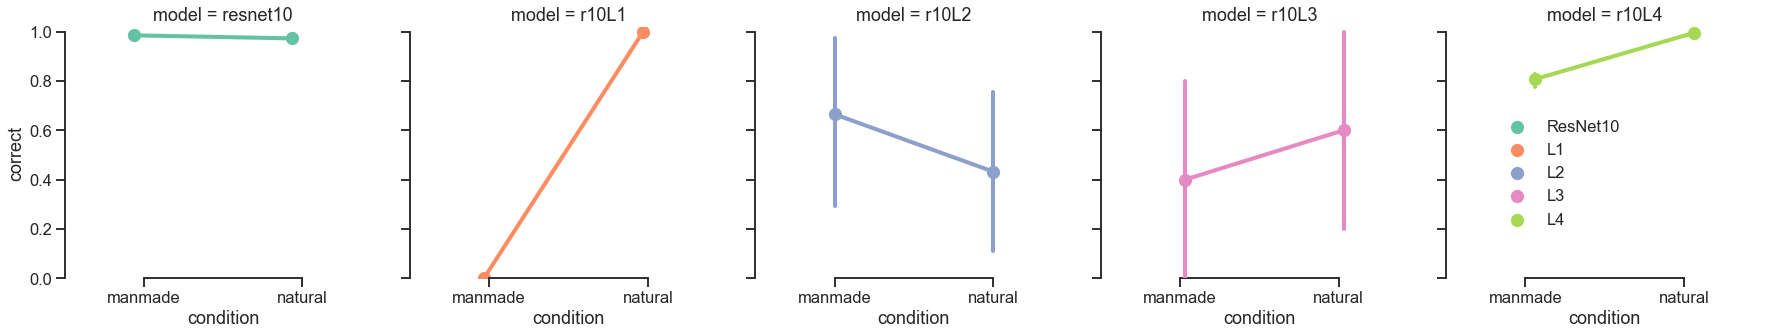

In [78]:
correctT = data.groupby(['model', 'initialization', 'condition'], as_index=False)['correct'].mean()

sns.set(style="ticks")
sns.set_context('talk')
ax = sns.catplot(x="condition", order=["manmade","natural"], y="correct",hue='model', hue_order=['resnet10', 'r10L1', 'r10L2', 'r10L3', 'r10L4'],col="model", col_order=["resnet10", "r10L1", "r10L2","r10L3","r10L4"],
                   data=correctT, palette="Set2",kind="point", dodge=True, ci=95, join=True, legend=False)
(ax.set(ylim=(0, 1.02)))
ax.add_legend(bbox_to_anchor=(0.85, 0.45))

# replace labels
new_labels = ['ResNet10','L1','L2','L3','L4']
for t, l in zip(ax._legend.texts, new_labels): t.set_text(l)
ax.despine(trim=True)


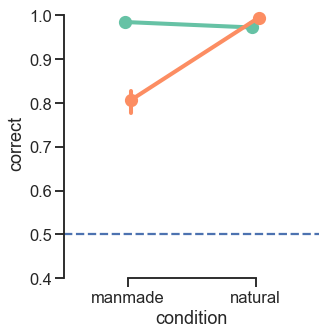

In [79]:
sns.set(style="ticks")
sns.set_context('talk')
ax = sns.catplot(x="condition", y="correct", hue="model", hue_order=['resnet10', 'r10L4'],
                   data=correctT, palette="Set2",kind="point",dodge=True, legend=False)
(ax.set(ylim=(0, 1.02)))
ax.axes[0][0].axhline(0.5, ls='--')
(ax.set(ylim=(0.4, 1.02)))
ax.despine(trim=True)

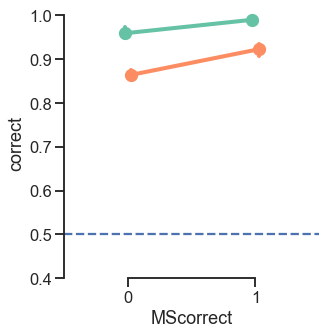

In [80]:
correctMS = data.groupby(['model', 'initialization', 'MScorrect'], as_index=False)['correct'].mean()
sns.set(style="ticks")
sns.set_context('talk')
ax = sns.catplot(x="MScorrect", y="correct", hue="model", hue_order=['resnet10', 'r10L4'],
                   data=correctMS, palette="Set2",kind="point",dodge=True, legend=False)
(ax.set(ylim=(0, 1.02)))
ax.axes[0][0].axhline(0.5, ls='--')
(ax.set(ylim=(0.4, 1.02)))
ax.despine(trim=True)

In [81]:
dataa= correctMS[correctMS['model']=='r10L4']
c1 = dataa[dataa['MScorrect']==1]["correct"]
c2 = dataa[dataa['MScorrect']==0]["correct"]
stats = two_sample_permutation(c1, c2, n_permute=5000, return_perms=True)
print(stats['p'])

0.007798440311937612


In [83]:
sns.set(style="ticks")
sns.set_context('talk')
dataa= correctMS[correctMS['model']=='resnet10']
c1 = dataa[dataa['MScorrect']==1]["correct"]
c2 = dataa[dataa['MScorrect']==0]["correct"]
stats = two_sample_permutation(c1, c2, n_permute=5000, return_perms=True)
print(stats['p'])

0.008198360327934412
